In [2]:
import pandas as pd
def fetch_data(ticker,start_date,end_date):
  import yfinance as yf
  from datetime import datetime, timedelta

  data = pd.DataFrame(index=pd.bdate_range(start=start_date,end=end_date))

  data['day_of_year'] = data.index.day_of_year
  data['month'] = data.index.month
  data['year'] = data.index.strftime('%Y')

  end_date1 = datetime(int(end_date.split('-')[0]),int(end_date.split('-')[1]),int(end_date.split('-')[2]))+timedelta(days=1)
  fetched_data = yf.download(tickers=ticker,start=start_date,end=end_date1.strftime('%Y-%m-%d'),period='1d')
  data = data.join(fetched_data)

  data['oil_Close'] = yf.download(tickers="CL=F",start=start_date,end=end_date1.strftime('%Y-%m-%d'),period='1d')['Close']
  data['NIFTY50_Close'] = yf.download(tickers="^NSEI",start=start_date,end=end_date1.strftime('%Y-%m-%d'),period='1d')['Close']

  data.fillna(method='ffill',inplace=True) #filling up missing dates
  return data

In [3]:
start_date = '2013-01-01'
end_date = '2023-06-15'
data = fetch_data("RELIANCE.NS",start_date,end_date)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense, LSTM

import xgboost
from xgboost import XGBRegressor, plot_importance, plot_tree

from hyperopt import hp
from scipy.stats import uniform, randint

In [5]:
pip install hyperpot

     ---------------------------------------- 1.6/1.6 MB 1.1 MB/s eta 0:00:00
     ------------------------------------ 200.5/200.5 kB 528.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
data

,day_of_year,month,year,Open,High,Low,Close,Adj Close,Volume,oil_Close,NIFTY50_Close
2013-01-01,1,1,2013,418.037415,419.325226,415.610443,416.402924,387.885101,3152667.0,NaN,NaN
2013-01-02,2,1,2013,418.037415,423.981079,417.319244,419.993866,391.230164,6203434.0,93.120003,5993.250000
2013-01-03,3,1,2013,420.315826,426.952911,418.334595,426.333771,397.135834,7968629.0,92.919998,6009.500000
2013-01-04,4,1,2013,426.903381,428.240692,422.767578,426.878632,397.643463,6140890.0,93.089996,6016.149902
2013-01-07,7,1,2013,428.785553,431.410645,421.900787,424.278259,395.221130,7064261.0,93.190002,5988.399902
...,...,...,...,...,...,...,...,...,...,...,...
2023-06-09,160,6,2023,2507.000000,2508.550049,2478.000000,2481.949951,2481.949951,2712243.0,70.169998,18563.400391
2023-06-12,163,6,2023,2475.500000,2489.199951,2465.000000,2484.149902,2484.149902,2949893.0,67.120003,18601.500000
2023-06-13,164,6,2023,2495.000000,2523.449951,2486.250000,2520.850098,2520.850098,5190958.0,69.419998,18716.150391
2023-06-14,165,6,2023,2521.000000,2555.000000,2517.000000,2551.850098,2551.850098,6127509.0,68.269997,18755.900391


In [8]:
pre_covid = data[:'2020-02-29'].copy()

In [9]:
post_covid = data['2020-09-01':].copy()

# Model Building

In [11]:
#LSTM
df = post_covid[['Close']].copy()

In [12]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df = scaler.fit_transform(np.array(df).reshape(-1,1))
df.shape

(728, 1)

In [13]:
## splitting dataset into train and test split
training_size = int(len(df)*0.65)
test_size = len(df) - training_size
train_data, test_data = df[0:training_size,:], df[training_size:len(df),:1]
print(len(train_data),len(test_data))

473 255


In [14]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
# reshape into X=t,t+1,t+2,t+3, and t+4
time_step = 80
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [16]:
y_test[0:4]

array([0.54069938, 0.57960933, 0.6230698 , 0.66668356])

In [17]:
## reshape input to be [samples, time steps, features] which is requires for LSTM
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [18]:
## Create LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(80,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 80, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 80, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
7/7 [==============================] - 15s 646ms/step - loss: 0.1157 - val_loss: 0.1237
Epoch 2/100
7/7 [==============================] - 1s 180ms/step - loss: 0.0401 - val_loss: 0.0339
Epoch 3/100
7/7 [==============================] - 1s 172ms/step - loss: 0.0277 - val_loss: 0.0071
Epoch 4/100
7/7 [==============================] - 1s 172ms/step - loss: 0.0166 - val_loss: 0.0099
Epoch 5/100
7/7 [==============================] - 2s 255ms/step - loss: 0.0139 - val_loss: 0.0098
Epoch 6/100
7/7 [==============================] - 2s 298ms/step - loss: 0.0134 - val_loss: 0.0081
Epoch 7/100
7/7 [==============================] - 2s 258ms/step - loss: 0.0125 - val_loss: 0.0063
Epoch 8/100
7/7 [==============================] - 2s 256ms/step - loss: 0.0122 - val_loss: 0.0064
Epoch 9/100
7/7 [==============================] - 2s 239ms/step - loss: 0.0111 - val_loss: 0.0078
Epoch 10/100
7/7 [==============================] - 2s 243ms/step - loss: 0.0111 - val_loss: 0.0058
Epoch 11

7/7 [==============================] - 1s 196ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 84/100
7/7 [==============================] - 1s 200ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 85/100
7/7 [==============================] - 1s 201ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 86/100
7/7 [==============================] - 1s 196ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 87/100
7/7 [==============================] - 1s 202ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 88/100
7/7 [==============================] - 1s 202ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 89/100
7/7 [==============================] - 2s 239ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 90/100
7/7 [==============================] - 2s 228ms/step - loss: 0.0034 - val_loss: 0.0018
Epoch 91/100
7/7 [==============================] - 2s 231ms/step - loss: 0.0032 - val_loss: 0.0018
Epoch 92/100
7/7 [==============================] - 2s 225ms/step - loss: 0.0030 - val_loss: 0.0039
Epoch 93/100


In [22]:
## Lets do the prediction and check performance metrics
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

6/6 [==============================] - 0s 42ms/step


In [23]:
y_test = y_test.reshape(len(y_test),1)
y_train = y_train.reshape(len(y_train),1)

In [24]:
## Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [31]:
def prediction_error(test_data, pred_data):
  print('RMSE:',np.sqrt(mean_squared_error(test_data,pred_data)))

In [32]:
prediction_error(y_test,test_predict)

RMSE: 38.97262362911885


In [33]:
## shift train predictions for plotting
look_back = 80
## shift test predictions for plotting
testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+160+1:len(df)-1,:] = test_predict

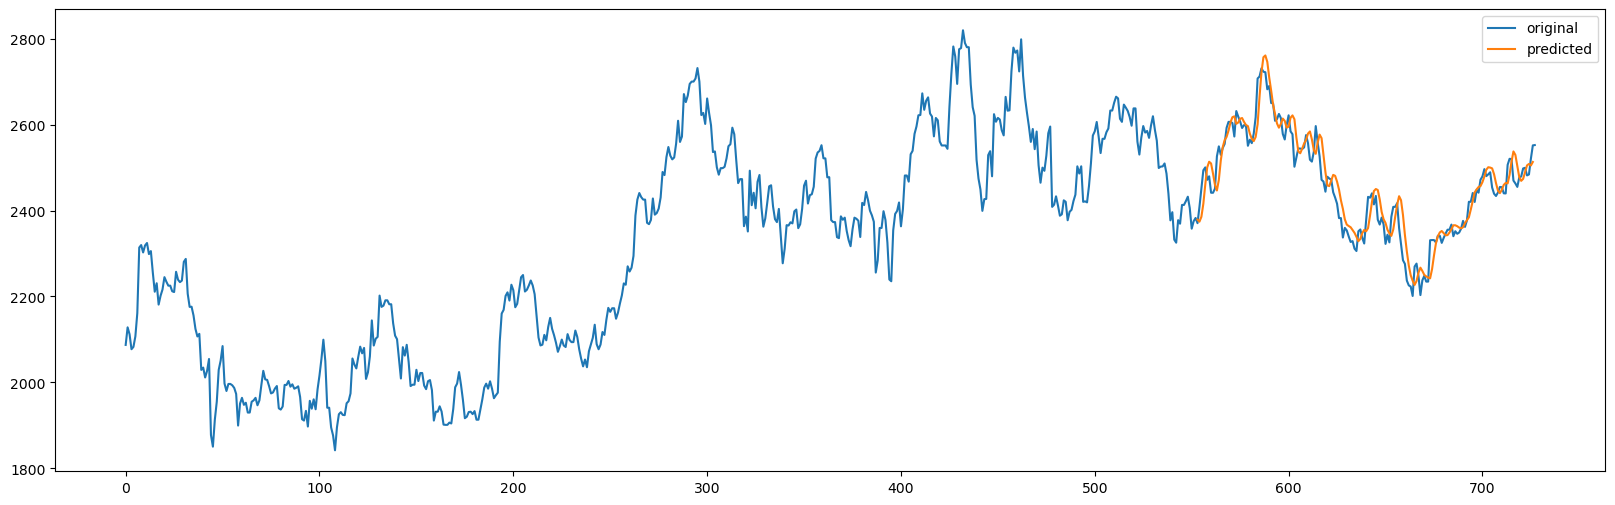

In [34]:
plt.figure(figsize=(20,6))
plt.plot(scaler.inverse_transform(df),label="original")
plt.plot(testPredictPlot,label="predicted")
plt.legend()

In [35]:
len(test_data)

255

In [36]:
test_data

array([[0.6729727 ],
       [0.66540531],
       [0.70124747],
       [0.75488275],
       [0.77073304],
       [0.57955815],
       [0.58467115],
       [0.60466301],
       [0.58277949],
       [0.55849275],
       [0.56186713],
       [0.59510161],
       [0.59157369],
       [0.54770428],
       [0.56774708],
       [0.57250231],
       [0.59341442],
       [0.60860012],
       [0.67598931],
       [0.65891196],
       [0.67609167],
       [0.59152251],
       [0.59264747],
       [0.59029544],
       [0.62905211],
       [0.68258503],
       [0.74946317],
       [0.75948445],
       [0.78167505],
       [0.74644631],
       [0.70768989],
       [0.74158896],
       [0.74158896],
       [0.75728596],
       [0.76608041],
       [0.80892722],
       [0.80892722],
       [0.82764084],
       [0.84180369],
       [0.83786683],
       [0.78934455],
       [0.7819307 ],
       [0.82303914],
       [0.81582977],
       [0.8079558 ],
       [0.79358823],
       [0.77277824],
       [0.813

In [37]:
x_test.shape

(174, 80, 1)

In [38]:
x_input = test_data[175:].reshape(1,-1)
x_input.shape

(1, 80)

In [39]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.5539931678583259,
 0.5377851188334779,
 0.4914613208557579,
 0.513293666000995,
 0.4950404183869146,
 0.5557315367275673,
 0.579558150223731,
 0.579558150223731,
 0.5884037839169796,
 0.5289906650365663,
 0.4916146108867381,
 0.4525513677640054,
 0.4438080938634308,
 0.4040290811660727,
 0.3926269492362835,
 0.38976387093778286,
 0.3674199764872068,
 0.4374168482720793,
 0.44447293319974945,
 0.41502202358319695,
 0.36951635497277624,
 0.40454038081338095,
 0.4152264935105141,
 0.4016258729605122,
 0.4016258729605122,
 0.5001534148599955,
 0.5005623547146298,
 0.5005623547146298,
 0.49483594845959744,
 0.5107883476607917,
 0.5107883476607917,
 0.49381334916498143,
 0.5055732410530676,
 0.5161058140611898,
 0.5251559176817555,
 0.5251559176817555,
 0.5373759293208129,
 0.5096636382315325,
 0.5215768201505988,
 0.5154924042792384,
 0.5185090222667503,
 0.5277124159182958,
 0.5461703831177245,
 0.5319051728894346,
 0.5471929824123409,
 0.5916248718318082,
 0.5916248718318082,
 0.612639

In [40]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=80
i=0
while(i<30):

    if(len(temp_input)>80):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.7340618]
81
1 day input [0.53778512 0.49146132 0.51329367 0.49504042 0.55573154 0.57955815
 0.57955815 0.58840378 0.52899067 0.49161461 0.45255137 0.44380809
 0.40402908 0.39262695 0.38976387 0.36741998 0.43741685 0.44447293
 0.41502202 0.36951635 0.40454038 0.41522649 0.40162587 0.40162587
 0.50015341 0.50056235 0.50056235 0.49483595 0.51078835 0.51078835
 0.49381335 0.50557324 0.51610581 0.52515592 0.52515592 0.53737593
 0.50966364 0.52157682 0.5154924  0.51850902 0.52771242 0.54617038
 0.53190517 0.54719298 0.59162487 0.59162487 0.61263934 0.59121593
 0.61974635 0.61335511 0.64418638 0.65200941 0.66944478 0.65277636
 0.65691794 0.66192857 0.62567748 0.61084979 0.60548114 0.61355958
 0.62690455 0.62644443 0.61182121 0.61151438 0.67956841 0.69398716
 0.69332232 0.64214118 0.63534099 0.62710902 0.64965738 0.65180494
 0.67102961 0.67256351 0.65446355 0.65671322 0.69424281 0.72594339
 0.72665916 0.73406178]
1 day output [[0.74938]]
2 day input [0.49146132 0.51329367 0.49504042 0.55573

10 day output [[0.7914048]]
11 day input [0.45255137 0.44380809 0.40402908 0.39262695 0.38976387 0.36741998
 0.43741685 0.44447293 0.41502202 0.36951635 0.40454038 0.41522649
 0.40162587 0.40162587 0.50015341 0.50056235 0.50056235 0.49483595
 0.51078835 0.51078835 0.49381335 0.50557324 0.51610581 0.52515592
 0.52515592 0.53737593 0.50966364 0.52157682 0.5154924  0.51850902
 0.52771242 0.54617038 0.53190517 0.54719298 0.59162487 0.59162487
 0.61263934 0.59121593 0.61974635 0.61335511 0.64418638 0.65200941
 0.66944478 0.65277636 0.65691794 0.66192857 0.62567748 0.61084979
 0.60548114 0.61355958 0.62690455 0.62644443 0.61182121 0.61151438
 0.67956841 0.69398716 0.69332232 0.64214118 0.63534099 0.62710902
 0.64965738 0.65180494 0.67102961 0.67256351 0.65446355 0.65671322
 0.69424281 0.72594339 0.72665916 0.73406178 0.74937999 0.76015931
 0.76866049 0.775572   0.78101069 0.78505033 0.787848   0.78964257
 0.79072315 0.79140478]
11 day output [[0.79200196]]
12 day input [0.44380809 0.40402908

20 day output [[0.8206189]]
21 day input [0.40454038 0.41522649 0.40162587 0.40162587 0.50015341 0.50056235
 0.50056235 0.49483595 0.51078835 0.51078835 0.49381335 0.50557324
 0.51610581 0.52515592 0.52515592 0.53737593 0.50966364 0.52157682
 0.5154924  0.51850902 0.52771242 0.54617038 0.53190517 0.54719298
 0.59162487 0.59162487 0.61263934 0.59121593 0.61974635 0.61335511
 0.64418638 0.65200941 0.66944478 0.65277636 0.65691794 0.66192857
 0.62567748 0.61084979 0.60548114 0.61355958 0.62690455 0.62644443
 0.61182121 0.61151438 0.67956841 0.69398716 0.69332232 0.64214118
 0.63534099 0.62710902 0.64965738 0.65180494 0.67102961 0.67256351
 0.65446355 0.65671322 0.69424281 0.72594339 0.72665916 0.73406178
 0.74937999 0.76015931 0.76866049 0.775572   0.78101069 0.78505033
 0.787848   0.78964257 0.79072315 0.79140478 0.79200196 0.79280424
 0.79405314 0.79592383 0.79851508 0.80184585 0.80586129 0.8104434
 0.81542754 0.82061893]
21 day output [[0.82580996]]
22 day input [0.41522649 0.40162587 

In [41]:
day_new=np.arange(1,81)
day_pred=np.arange(81,111)

In [42]:
day_new

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

In [43]:
day_pred

array([ 81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110])

In [44]:
len(df)

728

In [55]:
728-81

647

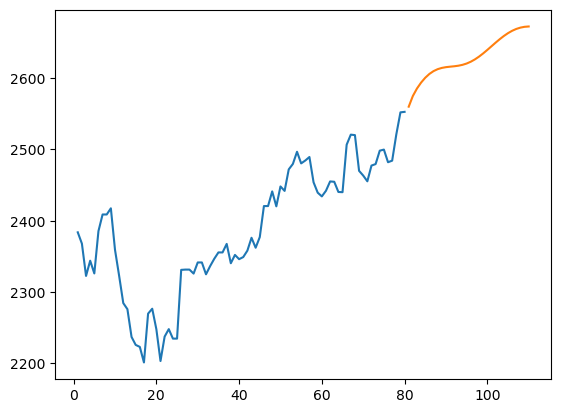

In [46]:
plt.plot(day_new,scaler.inverse_transform(df[648:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

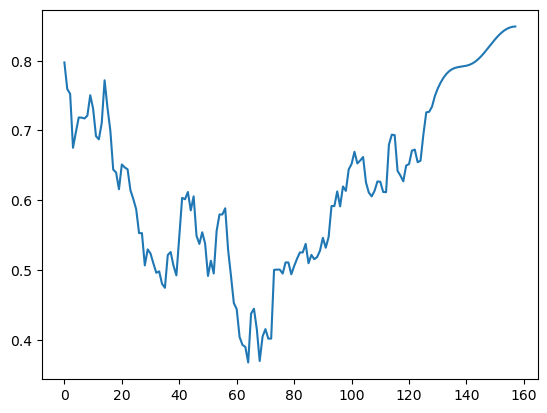

In [47]:
df1=df.tolist()
df1.extend(lst_output)
plt.plot(df1[600:])

In [48]:
df1=scaler.inverse_transform(df1).tolist()

In [49]:
len(df1)

758

In [58]:
import yfinance as yf
from datetime import datetime, timedelta
new_data = yf.download(tickers="RELIANCE.NS",start="2020-09-01",end="2023-06-25",period='1d')

[*********************100%***********************]  1 of 1 completed


In [59]:
new_data = new_data[['Close']].copy()

In [60]:
new_data =np.array(new_data).reshape(-1,1)


In [61]:
new_data

array([[2087.25      ],
       [2128.19995117],
       [2112.10009766],
       [2077.25      ],
       [2082.64990234],
       [2107.10009766],
       [2161.35009766],
       [2314.        ],
       [2319.75      ],
       [2302.55004883],
       [2318.85009766],
       [2324.55004883],
       [2298.75      ],
       [2305.69995117],
       [2255.85009766],
       [2211.14990234],
       [2230.80004883],
       [2181.19995117],
       [2201.69995117],
       [2216.25      ],
       [2245.05004883],
       [2234.35009766],
       [2225.25      ],
       [2212.19995117],
       [2210.35009766],
       [2257.5       ],
       [2239.25      ],
       [2233.44995117],
       [2237.05004883],
       [2280.69995117],
       [2287.5       ],
       [2206.5       ],
       [2175.80004883],
       [2176.19995117],
       [2155.89990234],
       [2124.60009766],
       [2106.94995117],
       [2113.05004883],
       [2029.09997559],
       [2034.5       ],
       [2011.44995117],
       [2026.900

In [65]:
df1

[[2087.25],
 [2128.199951171875],
 [2112.10009765625],
 [2077.25],
 [2082.64990234375],
 [2107.10009765625],
 [2161.35009765625],
 [2314.0],
 [2319.75],
 [2302.550048828125],
 [2318.85009765625],
 [2324.550048828125],
 [2298.75],
 [2305.699951171875],
 [2255.85009765625],
 [2211.14990234375],
 [2230.800048828125],
 [2181.199951171875],
 [2201.699951171875],
 [2216.25],
 [2245.050048828125],
 [2234.35009765625],
 [2225.25],
 [2225.25],
 [2212.199951171875],
 [2210.35009765625],
 [2257.5],
 [2239.25],
 [2233.449951171875],
 [2237.050048828125],
 [2280.699951171875],
 [2287.5],
 [2206.5],
 [2175.800048828125],
 [2176.199951171875],
 [2155.89990234375],
 [2124.60009765625],
 [2106.949951171875],
 [2113.050048828125],
 [2029.0999755859373],
 [2034.5],
 [2011.449951171875],
 [2026.9000244140627],
 [2054.5],
 [1877.449951171875],
 [1850.4000244140625],
 [1913.199951171875],
 [1955.0],
 [2029.1500244140623],
 [2050.699951171875],
 [2084.550048828125],
 [1997.199951171875],
 [1980.0],
 [1996.40

In [64]:
len(new_data)

699

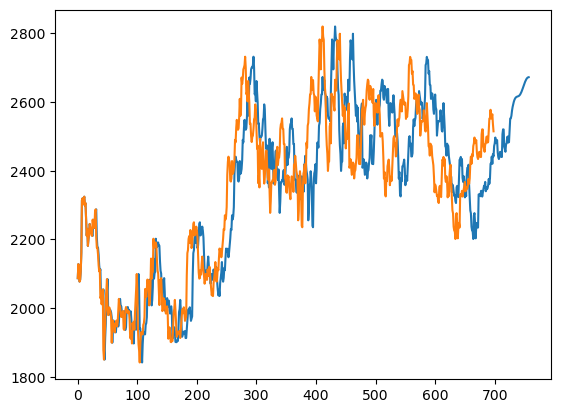

In [63]:
plt.plot(df1)
plt.plot(new_data)

In [66]:
# XGBoost
data2 = data[['Close']].copy()

data2['target'] = data2['Close'].shift(-1)
data2.dropna(inplace=True)
data2.head()

,Close,target
2013-01-01,416.402924,419.993866
2013-01-02,419.993866,426.333771
2013-01-03,426.333771,426.878632
2013-01-04,426.878632,424.278259
2013-01-07,424.278259,421.331207


In [67]:
train = data2.iloc[:-30]
test = data2.iloc[-30:]
print(train.shape, test.shape)

(2697, 2) (30, 2)


In [68]:
def xgb_predict(train,test):
  train_matrix, test_matrix = train.to_numpy(), test.to_numpy()
  test_x, test_y = test_matrix[:,:-1], test_matrix[:,1]
  pred = np.empty(shape=len(test_y))
  for i in range(len(test_y)):
    train_x, train_y = train_matrix[:,:-1], train_matrix[:,1]
    xgb = XGBRegressor()
    xgb.fit(train_x,train_y)
    pred[i] = xgb.predict(test_x[i])
    train_matrix = np.append(train_matrix,[test_matrix[i]],axis=0)
  return pred

In [69]:
y_pred = pd.Series(xgb_predict(train,test),index=test.index)

In [70]:
prediction_error(test['target'],y_pred)

RMSE: 31.660279247994964


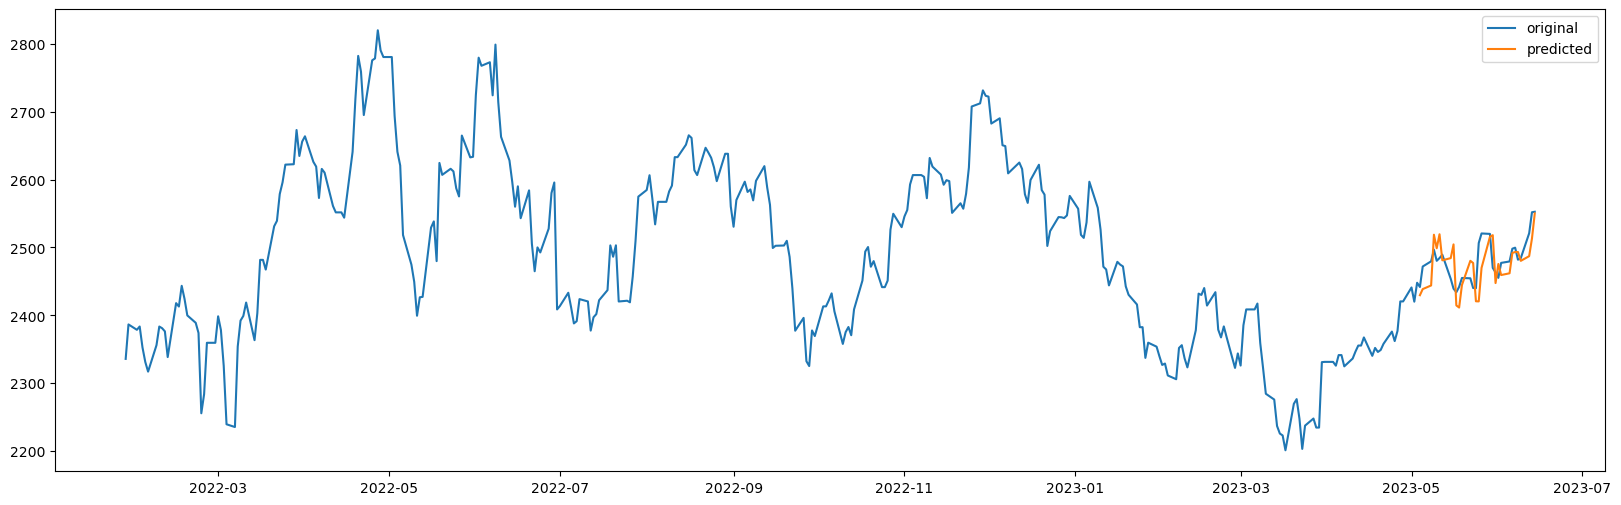

In [71]:
plt.figure(figsize=(20,6))
plt.plot(data2['target'][-360:],label="original")
plt.plot(y_pred,label="predicted")
plt.legend()